<a href="https://colab.research.google.com/github/agnanp/MLT2-COCO4/blob/main/car_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os

In [ ]:
print('Image(Train):',len(os.listdir('/content/drive/MyDrive/dts/data/training_images')))
print('Image(Test):',len(os.listdir('/content/drive/MyDrive/dts/data/testing_images')))

Image(Train): 1001
Image(Test): 175


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/dts/data/train_solution_bounding_boxes (1).csv")

In [ ]:
data.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


## Check Annotations

(380, 676, 3)
(380, 676, 3)
(380, 676, 3)


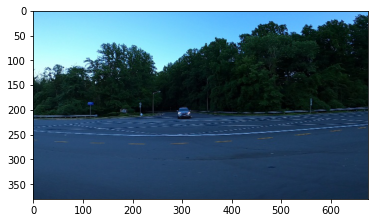

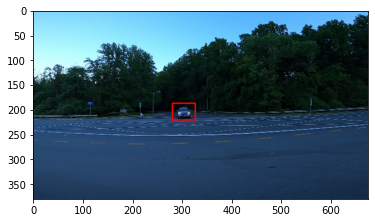

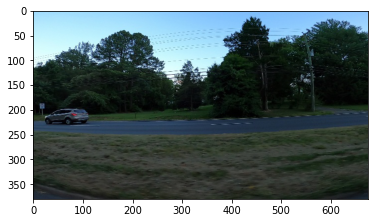

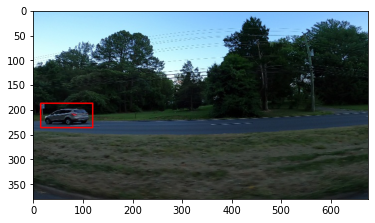

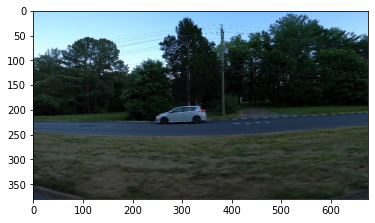

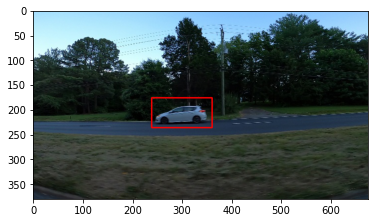

In [ ]:
for a,i in enumerate(data.values):
  img=plt.imread('/content/drive/MyDrive/dts/data/training_images/'+i[0])
  print(img.shape)
  plt.figure()
  plt.imshow(img)
  xmin=int(i[1])
  ymin=int(i[2])
  xmax=int(i[3])
  ymax=int(i[4])
  cv2.rectangle(img,(xmin, ymin),(xmax, ymax),(255, 0, 0),2)
  plt.figure()
  plt.imshow(img)
  if a ==2:
    break

## Selective Search and Prepare the dataset

In [ ]:
# variable
base_path='/content/drive/MyDrive/dts/data/'
max_proposals = 2000
max_proposals_infer = 200

In [ ]:
#Iou and selective search 
# run selective search on the image and init list of proposed boxes
cv2.setUseOptimized(True)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
def get_iou(bb1, bb2):

    assert bb1['x1'] < bb1['x2'] #bb1
    assert bb1['y1'] < bb1['y2']

    assert bb2['x1'] < bb2['x2'] #bb2
    assert bb2['y1'] < bb2['y2'];

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
      return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [ ]:
# make roi from original dataset
image_list=[]
k=0
l=0
z=0 
for gt_data in pd.read_csv(base_path + 'train_solution_bounding_boxes (1).csv').values:
  # Ground-truth bounding boxes
  Name,xmin,ymin,xmax,ymax=gt_data
  gt_bbox={
        'x1':int(xmin),
        'y1':int(ymin),
        'x2':int(xmax),
        'y2':int(ymax)
      }
  try:
    img=cv2.imread(base_path + 'training_images/'+Name)
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    #loop over region proposals
    for proposed_bbox in rects[:max_proposals]:
      # Proposed bounding boxes
      x, y, w, h = proposed_bbox 
      pp_bbox={'x1':x, 
          'y1':y,
          'x2':x+w,
          'y2':y+h
          }
      # Crop images
      img1=img[pp_bbox['y1']:pp_bbox['y2'],pp_bbox['x1']:pp_bbox['x2']] 
      img1_shape=cv2.resize(img1,(224,224))
      if k<l:
            if 0.5<get_iou(gt_bbox,pp_bbox):  
              image_list.append([img1_shape,1])
              k+=1
      else:
        if 0.5<get_iou(gt_bbox,pp_bbox):  
          image_list.append([img1_shape,1])
          k+=1
        else:
          image_list.append([img1_shape,0])
          l+=1
  except Exception as e:
    print('Exception var',e)
  z+=1
  print(Name,z,len(rects))

vid_4_1000.jpg 1 1101
vid_4_10000.jpg 2 1456
vid_4_10040.jpg 3 1403
vid_4_10020.jpg 4 1489
vid_4_10060.jpg 5 1315
vid_4_10100.jpg 6 1537
vid_4_10120.jpg 7 1430
vid_4_10140.jpg 8 1544
vid_4_1020.jpg 9 1117
vid_4_1040.jpg 10 1146
vid_4_10480.jpg 11 1663
vid_4_10500.jpg 12 1815
vid_4_10520.jpg 13 1725
vid_4_1060.jpg 14 1251
vid_4_10960.jpg 15 1894
vid_4_10980.jpg 16 1676
vid_4_11000.jpg 17 1754
vid_4_11020.jpg 18 1553
vid_4_11240.jpg 19 1779
vid_4_11260.jpg 20 1863
vid_4_11280.jpg 21 1846
vid_4_11380.jpg 22 1884
vid_4_11400.jpg 23 1929
vid_4_11420.jpg 24 1925
vid_4_11440.jpg 25 1880
vid_4_11900.jpg 26 1801
vid_4_11880.jpg 27 1824
vid_4_11920.jpg 28 1857
vid_4_11940.jpg 29 1947
vid_4_11960.jpg 30 1932
vid_4_11980.jpg 31 1970
vid_4_12000.jpg 32 1901
vid_4_12040.jpg 33 1979
vid_4_12100.jpg 34 1971
vid_4_12060.jpg 35 1879
vid_4_12080.jpg 36 1870
vid_4_12120.jpg 37 1821
vid_4_12140.jpg 38 1632
vid_4_12140.jpg 39 1632
vid_4_12160.jpg 40 1682
vid_4_12160.jpg 41 1682
vid_4_12160.jpg 42 1682
vid_4

In [ ]:
len(image_list)

10407

In [ ]:
data_img=[]
data_label=[]
for features,label in image_list:
  data_img.append(features)
  data_label.append(label)
print('success') 

success


In [ ]:
data_img=np.asarray(data_img)
data_label=np.asarray(data_label)

In [ ]:
data_img.shape

(10407, 224, 224, 3)

In [ ]:
data_label.shape

(10407,)

In [ ]:
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val=train_test_split(data_img,data_label,test_size=0.33, random_state=42)

In [ ]:
print('x_train shape:',x_train.shape)
print('x_val shape:',x_val.shape)
print('y_train shape:',y_train.shape)
print('y_val shape:',y_val.shape)

x_train shape: (6972, 224, 224, 3)
x_val shape: (3435, 224, 224, 3)
y_train shape: (6972,)
y_val shape: (3435,)


## Transfer Learning

In [ ]:
base_model = tf.keras.applications.VGG16(include_top=False,input_shape=(224,224,3),weights='imagenet')

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7fd7f1563c90>>

In [ ]:
head_model = base_model.output
head_model = tf.keras.layers.GlobalAveragePooling2D()(head_model)
head_model = tf.keras.layers.Dropout(0.5)(head_model)
head_model = tf.keras.layers.Dense(1,activation='sigmoid')(head_model)

model = tf.keras.models.Model(inputs=base_model.input, outputs=head_model)

In [ ]:
for i,layer in enumerate(base_model.layers):
  layer.trainable = False

In [ ]:
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics='accuracy')

In [ ]:
epoch=5
hist=model.fit(x_train,y_train,epochs=epoch,validation_data=(x_val,y_val))

Epoch 1/5
218/218 [==============================] - 65s 234ms/step - loss: 0.5278 - accuracy: 0.8490 - val_loss: 0.1623 - val_accuracy: 0.9569
Epoch 2/5
218/218 [==============================] - 50s 229ms/step - loss: 0.2495 - accuracy: 0.9332 - val_loss: 0.1353 - val_accuracy: 0.9718
Epoch 3/5
218/218 [==============================] - 53s 242ms/step - loss: 0.1935 - accuracy: 0.9443 - val_loss: 0.1213 - val_accuracy: 0.9738
Epoch 4/5
218/218 [==============================] - 52s 240ms/step - loss: 0.1711 - accuracy: 0.9508 - val_loss: 0.1103 - val_accuracy: 0.9750
Epoch 5/5
218/218 [==============================] - 53s 241ms/step - loss: 0.1653 - accuracy: 0.9505 - val_loss: 0.1104 - val_accuracy: 0.9750


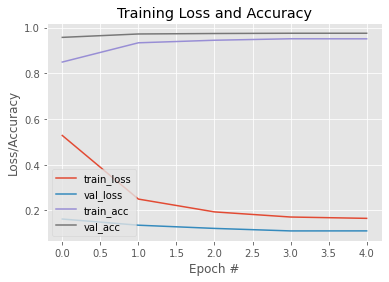

In [ ]:
N = epoch
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), hist.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), hist.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), hist.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), hist.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

Number of possible objects in the photo:  1492
how many possible bounty boxes with a class prediction of 1 are there: 1
-------------------------------------------------------------------------


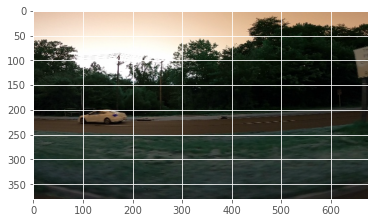

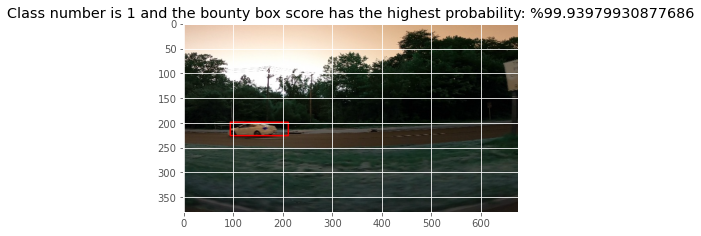

In [ ]:
car=[]
photo_path= base_path +'testing_images/vid_5_26840.jpg'
test_img=cv2.imread(photo_path)
ss.setBaseImage(test_img)
ss.switchToSelectiveSearchFast()
rects1 = ss.process()
print('Number of possible objects in the photo: ',len(rects1))
for i in rects1[:max_proposals_infer]:
  x, y, w, h = i
  bb3={'x1':x,
        'y1':y,
        'x2':x+w,
        'y2':y+h
      }
  try:
    assert bb3['x1'] < bb3['x2']
    assert bb3['y1'] < bb3['y2']
    img_data=test_img[bb3['y1']:bb3['y2'],bb3['x1']:bb3['x2']]
    img_data=cv2.resize(img_data,(224,224))
    pred=model.predict(img_data.reshape(1,224,224,3))
    if pred[0]>0.5:
      car.append([bb3,pred[0]])
    else:
      pass
  except Exception as e:
    print('Exception',e)
print('how many possible bounty boxes with a class prediction of 1 are there:',len(car))
print('-------------------------------------------------------------------------')
test_img=cv2.imread(photo_path)
car[np.argmax(np.array(car)[:,1])][0]
pt1=(car[np.argmax(np.array(car)[:,1])][0]['x1'],car[np.argmax(np.array(car)[:,1])][0]['y1'])
pt2=(car[np.argmax(np.array(car)[:,1])][0]['x2'],car[np.argmax(np.array(car)[:,1])][0]['y2'])
plt.figure()
plt.imshow(test_img)
cv2.rectangle(test_img,pt1,pt2,(255, 0, 0),2)
plt.figure()
plt.title(f'Class number is 1 and the bounty box score has the highest probability: %{car[np.argmax(np.array(car)[:,1])][1][0]*100}') 
plt.imshow(test_img);